# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [10]:
import tensorflow as tf

from tqdm import tqdm_notebook
import keras
from keras import losses

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [2]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

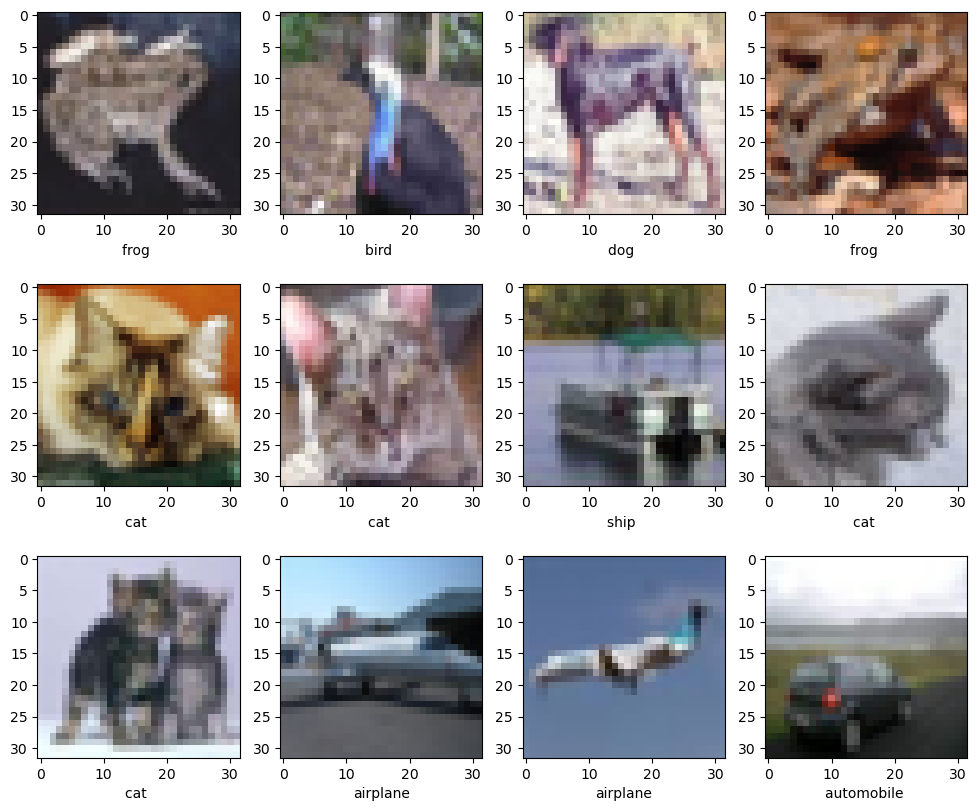

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [3]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [4]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [5]:
import keras
from keras import layers
from keras import backend as K

In [7]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')

])

/Users/vadim/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-19 15:33:40.904681: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-19 15:33:40.904705: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-19 15:33:40.904710: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-19 15:33:40.904728: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-19 15:33:40.904742: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created Ten

In [8]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

2024-07-19 15:33:59.549497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [12]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [10]:
## TODO
from keras import losses
model.compile(
    optimizer='sgd',
    loss=losses.categorical_crossentropy,
    metrics=['accuracy'],
)
model.fit(X_train, y_train, batch_size=128, epochs=16, validation_data=(X_val, y_val))

Epoch 1/16
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.1882 - loss: 2.1989 - val_accuracy: 0.2969 - val_loss: 1.9789
Epoch 2/16
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3103 - loss: 1.9424 - val_accuracy: 0.3211 - val_loss: 1.9002
Epoch 3/16
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3592 - loss: 1.8381 - val_accuracy: 0.3729 - val_loss: 1.7719
Epoch 4/16
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3876 - loss: 1.7558 - val_accuracy: 0.3815 - val_loss: 1.7752
Epoch 5/16
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4002 - loss: 1.7106 - val_accuracy: 0.3987 - val_loss: 1.6990
Epoch 6/16
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4152 - loss: 1.6728 - val_accuracy: 0.3911 - val_loss: 1.6943
Epoch 7/16
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4257 - loss: 1.6307 - val_accuracy: 0.4144 - val_loss: 1.6602
Epoch 8/16
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4327 - loss: 1.6108 - val_accu

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [11]:
from sklearn.metrics import accuracy_score

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

 Test_acc = 0.464
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [12]:
## TODO


new_model = keras.models.Sequential([
    layers.Input(shape=X_test.shape[1:]),
    layers.Conv2D(
        filters=10, 
        kernel_size=(3, 3), 
        activation='relu', 
        padding='same'
        ),
    layers.MaxPooling2D(
        pool_size=(2, 2),
        ),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [34]:
## TODO
new_model.compile(
    optimizer='adam',
    loss=losses.categorical_crossentropy,
    metrics=['accuracy'],
)
his_new_model = new_model.fit(X_train, y_train, batch_size=256, epochs=16, validation_data=(X_val, y_val))

Epoch 1/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6581 - loss: 0.9828 - val_accuracy: 0.6061 - val_loss: 1.1411
Epoch 2/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6659 - loss: 0.9580 - val_accuracy: 0.5976 - val_loss: 1.1562
Epoch 3/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6820 - loss: 0.9233 - val_accuracy: 0.6011 - val_loss: 1.1445
Epoch 4/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6860 - loss: 0.9031 - val_accuracy: 0.6035 - val_loss: 1.1514
Epoch 5/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6830 - loss: 0.9068 - val_accuracy: 0.6062 - val_loss: 1.1349
Epoch 6/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6967 - loss: 0.8776 - val_accuracy: 0.6019 - val_loss: 1.1457
Epoch 7/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6956 - loss: 0.8739 - val_accuracy: 0.6061 - val_loss: 1.1364
Epoch 8/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7054 - loss: 0.8514 - val_accu

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [42]:
from sklearn.metrics import accuracy_score

predict_x = new_model.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")
new_model_acc = test_acc

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

 Test_acc = 0.6162
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [21]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            print(f'Тренирую модель {model_name} c оптимизатором {optimizer_name}')
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, model.predict(X_test).argmax(axis=1))))

In [22]:
!rm -rf ./logs

In [23]:

## TODO
optimizers = {
    'sgd': 'sgd',
    'rmsprop': 'rmsprop', 
    'adam': 'adam',
}
models = {'simply' : model, 'cnn': new_model}

In [29]:
evaluator = Evaluator(models, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=512)
evaluator.evaluate(X_test, y_test, accuracy_score)

/var/folders/yv/y6gd0q0d7k14thdfy7xxxs140000gn/T/ipykernel_75353/2320340921.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):


  0%|          | 0/6 [00:00<?, ?it/s]

Тренирую модель simply c оптимизатором sgd
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - categorical_accuracy: 0.1616 - loss: 2.2455 - val_categorical_accuracy: 0.2340 - val_loss: 2.1535
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - categorical_accuracy: 0.2427 - loss: 2.1029 - val_categorical_accuracy: 0.2416 - val_loss: 2.0524
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - categorical_accuracy: 0.2800 - loss: 2.0211 - val_categorical_accuracy: 0.3031 - val_loss: 1.9721
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - categorical_accuracy: 0.3175 - loss: 1.9473 - val_categorical_accuracy: 0.2664 - val_loss: 2.0706
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - categorical_accuracy: 0.3295 - loss: 1.9198 - val_categorical_accuracy: 0.3341 - val_loss: 1.8874
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - categorical_accuracy: 0.3402 - loss: 1.8851 - val_categorical_accuracy: 0.2680 - val_loss: 2.0003
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48m

In [30]:
evaluator.evaluate(X_test, y_test, accuracy_score)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Final score of simply_sgd is 0.4574
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Final score of simply_rmsprop is 0.436
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Final score of simply_adam is 0.4105
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Final score of cnn_sgd is 0.5412
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Final score of cnn_rmsprop is 0.5931
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Final score of cnn_adam is 0.5881


In [31]:
!pwd

/Users/vadim/Code/Netology/DSNN-31/logs


Прокомментируйте полученные результаты.

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [ ]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [35]:
new_model_bn1 = keras.models.Sequential([
    layers.Input(shape=X_test.shape[1:]),
    layers.Conv2D(
        filters=10, 
        kernel_size=(3, 3), 
        activation='relu', 
        padding='same'
        ),
    layers.MaxPooling2D(
        pool_size=(2, 2),
        ),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(10, activation='softmax')
])

new_model_bn1.compile(
    optimizer='adam',
    loss=losses.categorical_crossentropy,
    metrics=['accuracy'],
)
his_new_model_bn1 = new_model_bn1.fit(X_train, y_train, batch_size=256, epochs=16, validation_data=(X_val, y_val))

Epoch 1/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.3850 - loss: 1.7761 - val_accuracy: 0.3842 - val_loss: 1.8826
Epoch 2/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5735 - loss: 1.2046 - val_accuracy: 0.4813 - val_loss: 1.5323
Epoch 3/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6413 - loss: 1.0232 - val_accuracy: 0.5129 - val_loss: 1.3745
Epoch 4/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6850 - loss: 0.9007 - val_accuracy: 0.5488 - val_loss: 1.3144
Epoch 5/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7298 - loss: 0.7787 - val_accuracy: 0.5995 - val_loss: 1.1779
Epoch 6/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7694 - loss: 0.6682 - val_accuracy: 0.5986 - val_loss: 1.2213
Epoch 7/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8053 - loss: 0.5758 - val_accuracy: 0.5789 - val_loss: 1.3478
Epoch 8/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8386 - loss: 0.4878 - val_acc

Прокомментируйте полученные результаты.

In [44]:
new_model_bn2 = keras.models.Sequential([
    layers.Input(shape=X_test.shape[1:]),
    layers.Conv2D(
        filters=10, 
        kernel_size=(3, 3), 
        activation='linear', 
        padding='same'
        ),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(
        pool_size=(2, 2),
        ),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),    
    layers.Dense(10, activation='softmax')
])
new_model_bn2.compile(
    optimizer='adam',
    loss=losses.categorical_crossentropy,
    metrics=['accuracy'],
)
his_new_model_bn2 = new_model_bn2.fit(X_train, y_train, batch_size=256, epochs=16, validation_data=(X_val, y_val))

Epoch 1/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.4045 - loss: 1.7357 - val_accuracy: 0.1705 - val_loss: 2.3181
Epoch 2/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5712 - loss: 1.2189 - val_accuracy: 0.3908 - val_loss: 1.7240
Epoch 3/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6236 - loss: 1.0755 - val_accuracy: 0.4742 - val_loss: 1.4557
Epoch 4/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6519 - loss: 0.9874 - val_accuracy: 0.5341 - val_loss: 1.3467
Epoch 5/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6857 - loss: 0.9142 - val_accuracy: 0.4988 - val_loss: 1.5662
Epoch 6/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7098 - loss: 0.8354 - val_accuracy: 0.5542 - val_loss: 1.3853
Epoch 7/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7349 - loss: 0.7719 - val_accuracy: 0.5858 - val_loss: 1.2126
Epoch 8/16
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7564 - loss: 0.7036 - val_acc

In [45]:
predict_x = new_model_bn1.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)
new_model_bn1_acc = accuracy_score(y_test, classes_x)

predict_x = new_model_bn2.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)
new_model_bn2_acc = accuracy_score(y_test, classes_x)
new_model_acc, new_model_bn1_acc, new_model_bn2_acc

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(0.6162, 0.5875, 0.5631)

Вывод простой. Нужно с темой нормализации еще разобраться :)


**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [52]:
from keras.callbacks import Callback

class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='val_accuracy', value=0.55, verbose=1):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            print("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [54]:
import datetime
delta = []
batch = range(5, 15)
for b in batch:
    test_model = keras.models.Sequential([
    layers.Input(shape=X_test.shape[1:]),
    layers.Conv2D(
        filters=10, 
        kernel_size=(3, 3), 
        activation='relu', 
        padding='same'
        ),
    layers.MaxPooling2D(
        pool_size=(2, 2),
        ),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(10, activation='softmax')
    ])
    # Не нашел способа сбросить модель
    test_model.compile(
        optimizer='adam',
        loss=losses.categorical_crossentropy,
        metrics=['accuracy'],
    )
    start = datetime.datetime.now()
    print(2**b)
    test_model.fit(X_train, y_train, 
                  batch_size=2**b, 
                  epochs=100, 
                  validation_data=(X_val, y_val),
                  callbacks=[EarlyStoppingByAccuracy()]
    )
    delta.append(datetime.datetime.now() - start)
    

32
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.3693 - loss: 1.7653 - val_accuracy: 0.5118 - val_loss: 1.3933
Epoch 2/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5440 - loss: 1.2923Epoch 00001: early stopping THR
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.5441 - loss: 1.2923 - val_accuracy: 0.5614 - val_loss: 1.2429
64
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.3361 - loss: 1.8534 - val_accuracy: 0.4796 - val_loss: 1.4703
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5007 - loss: 1.4225 - val_accuracy: 0.5234 - val_loss: 1.3427
Epoch 3/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5571 - loss: 1.2586Epoch 00002: early stopping THR
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.5571 - loss: 1.2586 - val_accuracy: 0.5655 - val_loss: 1.2275
128
Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.3237 - loss: 1.8963 - val_accuracy: 0.4811 - v

Text(0, 0.5, 'seconds')

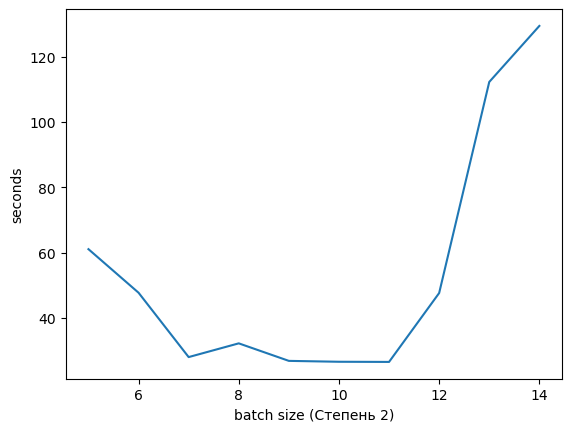

In [67]:
plt.plot(
    batch,
    [d.total_seconds() for d in delta]
    
)

plt.xlabel('batch size (Степень 2)')
plt.ylabel('seconds')

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [80]:
val_datagen = ImageDataGenerator()

split = 45000
dg_x_train, dg_x_val = X_train[:split], X_train[split:]
dg_y_train, dg_y_val = y_train[:split], y_train[split:]

In [24]:
## TODO
final_model = tf.keras.models.Sequential([
    layers.Input(shape=X_test.shape[1:]),
    layers.Conv2D(
        filters=16, 
        kernel_size=(3, 3), 
        activation='relu', 
        padding='same'
        ),
    layers.Conv2D(
        filters=16, 
        kernel_size=(3, 3), 
        activation='relu', 
        padding='same'
        ),   
    layers.MaxPooling2D(
        pool_size=(2, 2),
        ),
    layers.BatchNormalization(),
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        activation='relu', 
        padding='same'
        ),
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        activation='relu', 
        padding='same'
        ),
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        activation='relu', 
        padding='same'
        ),   
    layers.MaxPooling2D(
        pool_size=(2, 2),
        ),
    layers.BatchNormalization(),
    layers.Conv2D(
        filters=64, 
        kernel_size=(3, 3), 
        activation='relu', 
        padding='same'
        ),
    layers.Conv2D(
        filters=64, 
        kernel_size=(3, 3), 
        activation='relu', 
        padding='same'
        ),   
    layers.Conv2D(
        filters=64, 
        kernel_size=(3, 3), 
        activation='relu', 
        padding='same'
        ),   
    layers.MaxPooling2D(
        pool_size=(2, 2),
        ),
    layers.BatchNormalization(),
    layers.Flatten(), 
    layers.Dense(200, activation='relu'),
    layers.Dense(10, activation='softmax')
])

final_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 200)            │       205,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 325,714 (1.24 MB)

 Trainable params: 325,490 (1.24 MB)

 Non-trainable params: 224 (896.00 B)

In [17]:
final_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

In [28]:
## TODO
## Введеный код выдавал ошибку 
## ValueError: Must provide at least one structure
final_model.compile(
    optimizer='adam',
    loss=losses.categorical_crossentropy,
    metrics=['accuracy'],

)
batch_size = 1024

final_model.fit(
    X_train, y_train, 
    epochs=32, 
    batch_size=batch_size,
#    callbacks=final_callbacks, 
    validation_data=(X_val, y_val)
)


Epoch 1/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.9893 - loss: 0.0320 - val_accuracy: 0.7466 - val_loss: 1.7447
Epoch 2/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.9949 - loss: 0.0149 - val_accuracy: 0.7466 - val_loss: 1.7660
Epoch 3/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.9983 - loss: 0.0064 - val_accuracy: 0.7448 - val_loss: 1.7993
Epoch 4/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 0.7519 - val_loss: 1.7595
Epoch 5/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 1.0000 - loss: 5.4433e-04 - val_accuracy: 0.7572 - val_loss: 1.7171
Epoch 6/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 1.0000 - loss: 2.9027e-04 - val_accuracy: 0.7591 - val_loss: 1.7207
Epoch 7/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 1.0000 - loss: 2.0386e-04 - val_accuracy: 0.7587 - val_loss: 1.7134
Epoch 8/32
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.9999 - loss: 6.6763e-04 -

Момент истины: проверьте, какого качества достигла ваша сеть.

In [29]:
from sklearn.metrics import accuracy_score

predict_x=final_model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 Test_acc = 0.7233


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.